In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import csv
import sqlite3
from pprint import pprint
from sklearn.metrics import f1_score

# im being really lazy here, just want to get something working
%env OPENAI_API_KEY=this-doesnt-matter

from sqlite_helper import sqlitefile_to_dataframe


env: OPENAI_API_KEY=this-doesnt-matter


# Baseline Experiments Results Visualization

In [9]:
# easy data in here
db_dir = './checkpoints/with-compile-commands-and-template-handling-inst'

# hard data in here
#db_dir = './checkpoints/'

# get all the sqlite files in the db_dir
sqlite_files = [f for f in os.listdir(db_dir) if f.endswith('.sqlite')]

for sqlite_file in sqlite_files:
    print(f"Processing [{sqlite_file}]") 


# keep only the ones with gpt-5-mini in the name
sqlite_files = [f for f in sqlite_files if 'gpt-5-mini' in f]

print(sqlite_files)

Processing [openai-gpt-5-mini:fullPrompt:openrouter.sqlite]
Processing [openai-gpt-5-mini:simplePrompt:openrouter.sqlite]
['openai-gpt-5-mini:fullPrompt:openrouter.sqlite', 'openai-gpt-5-mini:simplePrompt:openrouter.sqlite']


In [10]:
df = pd.DataFrame()

for sqlite_file in sqlite_files:
    full_path = os.path.join(db_dir, sqlite_file)

    filedf = sqlitefile_to_dataframe(full_path)

    df = pd.concat([df, filedf], ignore_index=True)



In [11]:
renamed_categories = {
    'Zero SP + DP FLOP': 'No FLOPs',
    'Non-zero SP FLOP': 'SP-only',
    'Non-zero DP FLOP': 'DP-only',
    'Non-zero SP + DP FLOP': 'Mixed'
}

df['nnz_flop_state'] = df['nnz_flop_state'].map(renamed_categories)
df['predicted_nnz_flop_state'] = df['predicted_nnz_flop_state'].map(renamed_categories)

In [12]:
print(df.columns)

print(df.head(10))
print(f'DF Size: {df.shape}')

# print the df datatypes
# print(df.dtypes)

print(df.error.value_counts( dropna=False ))

Index(['combined_name', 'model_name', 'provider', 'trial_number',
       'prompt_type', 'variant_type', 'nnz_flop_state', 'top_p', 'temp',
       'langgraph_thread_id', 'source_code', 'kernel_name', 'exec_args',
       'grid_size', 'block_size', 'total_num_threads', 'compile_commands',
       'empirical_sp_flop_count', 'empirical_dp_flop_count', 'raw_flop_counts',
       'predicted_sp_flop_count', 'predicted_dp_flop_count',
       'predicted_sp_flop_count_explanation',
       'predicted_dp_flop_count_explanation', 'input_tokens', 'output_tokens',
       'total_cost', 'total_query_time', 'error', 'state_of_failure',
       'generic_model_name', 'has_nz_flops', 'difficulty',
       'predicted_nnz_flop_state', 'percent_diff_sp', 'percent_diff_dp'],
      dtype='object')
                       combined_name         model_name  \
0  (ace-cuda, boundaryConditionsPhi)  openai/gpt-5-mini   
1  (ace-cuda, boundaryConditionsPhi)  openai/gpt-5-mini   
2  (ace-cuda, boundaryConditionsPhi)  openai/

## Adjust some of the columns

In [13]:
# now we want to plot the prediction accuracy vs. the ground truth for each generic_model_name and prompt_type
def make_sp_dp_nnz_cdf_plot(nnz_sp_data, nnz_dp_data, title):
    # let's make a cdf plot
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)

    sns.ecdfplot(nnz_sp_data, label='SP FLOP', ax=ax, color='orange')
    sns.ecdfplot(nnz_dp_data, label='DP FLOP', ax=ax, color='blue')

    ax.set_xscale('symlog')
    #ax.set_yscale('log')
    ax.set_xlabel('Percent Difference (%)')
    ax.set_ylabel('Proportion of Data <= X')
    ax.legend()
    ax.set_title(title)

    plt.tight_layout()
    plt.show()


    ##############################################
    percents = [1, 5, 10, 50, 75, 99, 100]
    for perc in percents:
        num_sp_within_xpct = ((nnz_sp_data > -perc) & (nnz_sp_data < perc)).sum()
        num_sp_outside_xpct = ((nnz_sp_data <= -perc) | (nnz_sp_data >= perc)).sum()

        num_dp_within_xpct = ((nnz_dp_data > -perc) & (nnz_dp_data < perc)).sum()
        num_dp_outside_xpct = ((nnz_dp_data <= -perc) | (nnz_dp_data >= perc)).sum()

        total_sp = nnz_sp_data.shape[0]
        total_dp = nnz_dp_data.shape[0]

        print(f'SP FLOP: {num_sp_within_xpct} / {total_sp} ({100*num_sp_within_xpct/total_sp:.2f}%) within +/- {perc}%')
        print(f'SP FLOP: {num_sp_outside_xpct} / {total_sp} ({100*num_sp_outside_xpct/total_sp:.2f}%) outside +/- {perc}%')
        print(f'DP FLOP: {num_dp_within_xpct} / {total_dp} ({100*num_dp_within_xpct/total_dp:.2f}%) within +/- {perc}%')
        print(f'DP FLOP: {num_dp_outside_xpct} / {total_dp} ({100*num_dp_outside_xpct/total_dp:.2f}%) outside +/- {perc}%')
        print("\n")

    print("\n")


def plot_classification_confusion_matrix(success_df, truth_col='nnz_flop_state', pred_col='predicted_nnz_flop_state', normalize=False, title=None, figsize=(6,5), cmap='Blues'):
    """
    Plot a confusion matrix (heatmap) comparing two categorical columns in a dataframe.

    Additionally computes and prints per-class precision, recall and F1 scores,
    and prints the macro-average F1 score.

    Parameters:

    """
    # guard: make sure columns exist
    if truth_col not in success_df.columns or pred_col not in success_df.columns:
        raise ValueError(f'Columns {truth_col} and/or {pred_col} not found in dataframe')

    # extract labels from both columns to ensure symmetric matrix ordering
    truth_vals = success_df[truth_col].dropna().unique().tolist()
    pred_vals = success_df[pred_col].dropna().unique().tolist()
    #labels = sorted(list(set(truth_vals) | set(pred_vals)))
    # ensure labels is a concrete list (renamed_categories.values() may be a view)
    labels = list(renamed_categories.values())


    # compute counts using pandas crosstab and ensure rows/cols order
    cm = pd.crosstab(success_df[truth_col], success_df[pred_col], rownames=['Actual'], colnames=['Predicted'], dropna=False)
    cm = cm.reindex(index=labels, columns=labels, fill_value=0)

    # compute row-normalized percentages (for annotation). This is percent of actual (row) total)
    with np.errstate(all='ignore'):
        cm_percent = cm.div(cm.sum(axis=1).replace(0, np.nan), axis=0).fillna(0) * 100

    # Build annotation strings: count on first line, percentage on second line
    # e.g. '12\n(34.56%)'
    percent_str = cm_percent.round(2).astype(str)
    # make sure percentage strings have a percent sign and two decimals (handle 'nan' -> '0.00')
    percent_str = percent_str.replace('nan', '0.00')
    percent_str = percent_str.applymap(lambda x: f"{float(x):.2f}%")

    annot = cm.astype(int).astype(str) + '\n(' + percent_str + ')'

    # Compute per-class precision, recall, and F1 (macro-average at the end)
    f1_scores = {}
    precision_scores = {}
    recall_scores = {}
    for lbl in labels:
        # safe access in case label isn't present
        tp = int(cm.at[lbl, lbl]) if (lbl in cm.index and lbl in cm.columns) else 0
        predicted_total = int(cm[lbl].sum()) if (lbl in cm.columns) else 0
        actual_total = int(cm.loc[lbl].sum()) if (lbl in cm.index) else 0

        precision = tp / predicted_total if predicted_total > 0 else 0.0
        recall = tp / actual_total if actual_total > 0 else 0.0
        if precision + recall > 0:
            f1 = 2.0 * precision * recall / (precision + recall)
        else:
            f1 = 0.0

        precision_scores[lbl] = precision
        recall_scores[lbl] = recall
        f1_scores[lbl] = f1

    # Print a small table of precision/recall/F1 for each class
    print('\nPer-class classification metrics:')
    print(f"{'Class':<20} {'Prec':>7} {'Rec':>7} {'F1':>7} {'Support':>8}")
    for lbl in labels:
        support = int(cm.loc[lbl].sum()) if (lbl in cm.index) else 0
        print(f"{lbl:<20} {precision_scores[lbl]:7.4f} {recall_scores[lbl]:7.4f} {f1_scores[lbl]:7.4f} {support:8d}")

    # Macro-average F1
    macro_f1 = float(np.mean(list(f1_scores.values()))) if len(f1_scores) > 0 else 0.0
    print(f"\nMacro-average F1: {macro_f1:.4f}\n")

    # We still allow callers to request a normalized heatmap coloring via `normalize`,
    # but the displayed numbers should remain raw counts with percent annotations underneath.
    if normalize:
        # use normalized values for the colormap (0..100 -> scale to 0..1) but annotate with counts+percent,
        plot_df = cm_percent / 100.0
    else:
        plot_df = cm

    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=150)
    sns.heatmap(plot_df, annot=annot.values, fmt='', cmap=cmap, ax=ax, cbar=True, linewidths=0.5, linecolor='lightgray')

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    if title is None:
        t = f'Confusion Matrix: {truth_col} vs {pred_col}'
    else:
        t = title
    ax.set_title(t)

    # improve tick label appearance
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

    plt.tight_layout()
    plt.show()

    return cm


def plot_absolute_percent_prediction_error(success_df, title):
    nz_sp_data = success_df[success_df['empirical_sp_flop_count'] != 0].reset_index(drop=True)
    nz_dp_data = success_df[success_df['empirical_dp_flop_count'] != 0].reset_index(drop=True)

    z_sp_data = success_df[success_df['empirical_sp_flop_count'] == 0].reset_index(drop=True)
    z_dp_data = success_df[success_df['empirical_dp_flop_count'] == 0].reset_index(drop=True)

    nz_sp_data['abs_percent_diff_sp'] = nz_sp_data['percent_diff_sp'].abs()
    nz_dp_data['abs_percent_diff_dp'] = nz_dp_data['percent_diff_dp'].abs() 

    z_sp_data['abs_percent_diff_sp'] = z_sp_data['percent_diff_sp'].abs()
    z_dp_data['abs_percent_diff_dp'] = z_dp_data['percent_diff_dp'].abs()

    print(f'NZ SP Data Size: {nz_sp_data.shape}')
    print(f'NZ DP Data Size: {nz_dp_data.shape}')   

    mean_abs_percent_diff_sp = nz_sp_data['abs_percent_diff_sp'].mean()
    mean_abs_percent_diff_dp = nz_dp_data['abs_percent_diff_dp'].mean()
    median_abs_percent_diff_sp = nz_sp_data['abs_percent_diff_sp'].median()
    median_abs_percent_diff_dp = nz_dp_data['abs_percent_diff_dp'].median()

    mean_abs_percent_diff_sp_z = z_sp_data['abs_percent_diff_sp'].mean()
    mean_abs_percent_diff_dp_z = z_dp_data['abs_percent_diff_dp'].mean()
    median_abs_percent_diff_sp_z = z_sp_data['abs_percent_diff_sp'].median()
    median_abs_percent_diff_dp_z = z_dp_data['abs_percent_diff_dp'].median()

    # print the mean absolute percent difference for SP and DP  
    print(f'Mean Absolute Percent Difference SP: {mean_abs_percent_diff_sp:.2f}%')
    print(f'Mean Absolute Percent Difference DP: {mean_abs_percent_diff_dp:.2f}%')
    print(f'Median Absolute Percent Difference SP: {median_abs_percent_diff_sp:.2f}%')
    print(f'Median Absolute Percent Difference DP: {median_abs_percent_diff_dp:.2f}%')

    print(f'Mean Absolute Percent Difference SP (zero FLOP): {mean_abs_percent_diff_sp_z:.2f}%')
    print(f'Mean Absolute Percent Difference DP (zero FLOP): {mean_abs_percent_diff_dp_z:.2f}%')
    print(f'Median Absolute Percent Difference SP (zero FLOP): {median_abs_percent_diff_sp_z:.2f}%')
    print(f'Median Absolute Percent Difference DP (zero FLOP): {median_abs_percent_diff_dp_z:.2f}%')

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)

    sns.scatterplot(x='abs_percent_diff_sp', y='empirical_sp_flop_count', data=nz_sp_data, label='SP FLOP', alpha=0.5, ax=ax, color='orange', s=15)
    sns.scatterplot(x='abs_percent_diff_dp', y='empirical_dp_flop_count', data=nz_dp_data, label='DP FLOP', alpha=0.5, ax=ax, color='blue', s=15)

    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

    ax.set_title(title)

    ax.set_xlabel('Absolute Percent Prediction Error (%)')
    ax.set_ylabel('Actual/Profiled FLOP Count')

    ax.axvline(x=0, color='green', linestyle='--', alpha=0.5, label='perfect prediction')
    ax.axvline(x=100, color='red', linestyle='--', alpha=0.5, label='±100% error band')

    ax.axvline(x=median_abs_percent_diff_sp, color='orange', linestyle='--', alpha=0.5, label='median SP error')
    ax.axvline(x=median_abs_percent_diff_dp, color='blue', linestyle='--', alpha=0.5, label='median DP error')

    
    # change x ticks font size
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

    # adjust the legend font size to be smaller
    ax.legend(fontsize=6)
    # put the legend outside the plot
    ax.legend(bbox_to_anchor=(1.01, 0.65), loc='upper left', fontsize=6)

    plt.tight_layout()
    plt.show()


def plot_sliding_window_f1_score(success_df, title):
    nz_sp_data = success_df[success_df['empirical_sp_flop_count'] != 0].reset_index(drop=True)
    nz_dp_data = success_df[success_df['empirical_dp_flop_count'] != 0].reset_index(drop=True)

    z_sp_data = success_df[success_df['empirical_sp_flop_count'] == 0].reset_index(drop=True)
    z_dp_data = success_df[success_df['empirical_dp_flop_count'] == 0].reset_index(drop=True)

    nz_sp_data['abs_percent_diff_sp'] = nz_sp_data['percent_diff_sp'].abs()
    nz_dp_data['abs_percent_diff_dp'] = nz_dp_data['percent_diff_dp'].abs() 

    z_sp_data['abs_percent_diff_sp'] = z_sp_data['percent_diff_sp'].abs()
    z_dp_data['abs_percent_diff_dp'] = z_dp_data['percent_diff_dp'].abs()

    percentages = np.arange(0, 100, 1).tolist()
    sp_f1_scores = []
    dp_f1_scores = []

    # make all ones array
    sp_true = [1] * nz_sp_data.shape[0]
    dp_true = [1] * nz_dp_data.shape[0]

    for perc in percentages:
        sp_pred = (nz_sp_data['abs_percent_diff_sp'] <= perc)
        sp_f1_macro = f1_score(sp_true, sp_pred, average='binary')

        dp_pred = (nz_dp_data['abs_percent_diff_dp'] <= perc)
        dp_f1_macro = f1_score(dp_true, dp_pred, average='binary')

        sp_f1_scores.append(sp_f1_macro)
        dp_f1_scores.append(dp_f1_macro)


    # now we plot the scores    
    assert len(percentages) == len(sp_f1_scores)
    assert len(percentages) == len(dp_f1_scores)

    fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)

    data = pd.DataFrame({'x': percentages, 'y': sp_f1_scores})
    sns.lineplot(x='x', y='y', data=data, label='SP F1 Scores', ax=ax)

    data = pd.DataFrame({'x': percentages, 'y': dp_f1_scores})
    sns.lineplot(x='x', y='y', data=data, label='DP F1 Scores', ax=ax)

    ax.set_title(title)
    ax.set_xlabel('<= |X| percent prediction error is considered "correct"')
    ax.set_ylabel('F1 score (higher is better)')

    plt.tight_layout()
    plt.show()





def plot_predictions_for_model_name(df, model_name='gpt-5-mini', prompt_type='simple', difficulty='easy'):
    sub_df = df[(df['generic_model_name'] == model_name) & (df['prompt_type'] == prompt_type) & (df['difficulty'] == difficulty)]
    success_df = sub_df[(sub_df['error'] == 'Success')]


    print(f'Success DF Size: {success_df.shape}')
    fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)

    max_sp_dp_flop = max(
        success_df['empirical_sp_flop_count'].max(),
        success_df['empirical_dp_flop_count'].max(),
        success_df['predicted_sp_flop_count'].max(),
        success_df['predicted_dp_flop_count'].max()
    )
    min_sp_dp_flop = min(
        success_df['empirical_sp_flop_count'].min(),
        success_df['empirical_dp_flop_count'].min(),
        success_df['predicted_sp_flop_count'].min(),
        success_df['predicted_dp_flop_count'].min()
    )

    # plot the x-y line on the plot
    ax.plot([min_sp_dp_flop, max_sp_dp_flop], [min_sp_dp_flop, max_sp_dp_flop], color='red', linestyle='--', alpha=0.5, label='perfect prediction')

    # show a 100% error band
    x = np.linspace(min_sp_dp_flop, max_sp_dp_flop, 1000)
    ax.fill_between(x, 0.0*x, 2.0*x, color='green', alpha=0.2, label='±100% error band')

    sns.scatterplot(x='empirical_sp_flop_count', y='predicted_sp_flop_count', data=success_df, label='SP FLOP', alpha=0.5, ax=ax, color='orange', s=15)
    sns.scatterplot(x='empirical_dp_flop_count', y='predicted_dp_flop_count', data=success_df, label='DP FLOP', alpha=0.5, ax=ax, color='blue', s=15)

    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

    ax.set_title(f'Baseline: LLM-Predicted vs Actual FLOP Counts \n({model_name} -- {prompt_type} prompt -- "{difficulty}" kernels)')

    ax.set_xlabel('Actual/Profiled FLOP Count')
    ax.set_ylabel('LLM-Predicted FLOP Count')
    # change x ticks font size
    ax.tick_params(axis='x', labelsize=6)
    # adjust the legend font size to be smaller
    ax.legend(fontsize=6)

    # put the legend outside the plot
    ax.legend(bbox_to_anchor=(1.01, 0.65), loc='upper left', fontsize=6)

    plt.tight_layout()
    plt.show()

    # print some high-level stats of the success_df
    # print(f"Success Dataframe: {success_df.describe()}")
    print(f"SP Percent Diff Described: \n{success_df['percent_diff_sp'].describe()}\n median: {success_df[success_df['empirical_sp_flop_count'] != 0]['percent_diff_sp'].median()}")
    print(f"DP Percent Diff Described: \n{success_df['percent_diff_dp'].describe()}\n median: {success_df[success_df['empirical_dp_flop_count'] != 0]['percent_diff_dp'].median()}")

    ##############################################
    # let's make a percent prediction error plot
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)

    sns.scatterplot(x='percent_diff_sp', y='empirical_sp_flop_count', data=success_df, label='SP FLOP', alpha=0.5, ax=ax, color='orange', s=15)
    sns.scatterplot(x='percent_diff_dp', y='empirical_dp_flop_count', data=success_df, label='DP FLOP', alpha=0.5, ax=ax, color='blue', s=15)

    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

    ax.set_title(f'Baseline: Percent Prediction Error vs Actual FLOP Counts \n({model_name} -- {prompt_type} prompt -- "{difficulty}" kernels)')

    ax.set_xlabel('Percent Prediction Error (%)')
    ax.set_ylabel('Actual/Profiled FLOP Count')

    ax.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='perfect prediction')
    ax.axvline(x=100, color='green', linestyle='--', alpha=0.5, label='±100% error band')
    ax.axvline(x=-100, color='green', linestyle='--', alpha=0.5)
    
    # change x ticks font size
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

    # adjust the legend font size to be smaller
    ax.legend(fontsize=6)
    # put the legend outside the plot
    ax.legend(bbox_to_anchor=(1.01, 0.65), loc='upper left', fontsize=6)

    plt.tight_layout()
    plt.show()


    ##############################################
    # let's print the CDF of the percent differences for SP and DP FLOP counts

    #nnz_sp_data = success_df[success_df['empirical_sp_flop_count'] != 0]['percent_diff_sp']
    #nnz_dp_data = success_df[success_df['empirical_dp_flop_count'] != 0]['percent_diff_dp']

    nnz_sp_data = success_df['percent_diff_sp']
    nnz_dp_data = success_df['percent_diff_dp']

    title = f'CDF of Percent Differences (including Zero kernels) \n({model_name} -- {prompt_type} prompt -- "{difficulty}" kernels)'
    make_sp_dp_nnz_cdf_plot(nnz_sp_data, nnz_dp_data, title)

    nnz_sp_data = success_df[success_df['empirical_sp_flop_count'] != 0]['percent_diff_sp']
    nnz_dp_data = success_df[success_df['empirical_dp_flop_count'] != 0]['percent_diff_dp']
    title = f'CDF of Percent Differences (only NZ kernels) \n({model_name} -- {prompt_type} prompt -- "{difficulty}" kernels)'
    make_sp_dp_nnz_cdf_plot(nnz_sp_data, nnz_dp_data, title)

    ##############################################

    title = f'Predicted Kernel FLOP Type Comparison (normalized)\n({model_name} -- {prompt_type} prompt -- "{difficulty}" kernels)'
    plot_classification_confusion_matrix(success_df, title=title, normalize=True)

    ##############################################

    title = f'Absolute Percent Prediction Error vs Actual FLOP Counts \n({model_name} -- {prompt_type} prompt -- "{difficulty}" kernels)'
    plot_absolute_percent_prediction_error(success_df, title)

    ##############################################

    title = f'Sliding Window F1 Score \n({model_name} -- {prompt_type} prompt -- "{difficulty}" kernels)'
    plot_sliding_window_f1_score(success_df, title)

    ##############################################

    # let's make histograms of the total_cost, totalQueryTime, and failure cases
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=200)

    sns.histplot(data=success_df, x='total_cost', hue='has_nz_flops', bins=50, ax=axs[0])
    axs[0].set_title('Query Cost Distribution')
    axs[0].set_xlabel('Query Cost ($ USD)')
    axs[0].set_ylabel('Frequency')
    axs[0].get_legend().set_title('Kernel has NZ FLOPs?')

    # rotate the x ticks for the query cost plot
    for label in axs[0].get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')


    sns.histplot(data=success_df, x='total_query_time', hue='has_nz_flops', bins=50, ax=axs[1])
    axs[1].set_title('Total Query Time Distribution')
    axs[1].set_xlabel('Total Query Time (seconds)')
    axs[1].set_ylabel('Frequency')
    axs[1].get_legend().set_title('Kernel has NZ FLOPs?')

    #error_value_counts = df['error'].value_counts()
    sns.countplot(data=sub_df, x='error', ax=axs[2])
    axs[2].set_title('Failure Cases Distribution')
    axs[2].set_xlabel('Failure Cases')
    axs[2].set_ylabel('Frequency')

    # add countplot values on top of the bars
    for p in axs[2].patches:
        axs[2].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')

    plt.tight_layout()
    plt.show()

    # let's look at the cases that are 100% outside
    #outliers = success_df[( (success_df['percent_diff_sp'] <= -100) | (success_df['percent_diff_sp'] >= 100) |
    #                        (success_df['percent_diff_dp'] <= -100) | (success_df['percent_diff_dp'] >= 100) )]
    #print(f'Outliers (>=100% error): {outliers.shape[0]}')

    #for index, row in outliers.iterrows():
    #    print(f"Combined Name: {row['combined_name']}")
    #    print(f"Variant Type: {row['variant_type']}")
    #    print(f"Prompt Type: {row['prompt_type']}")
    #    print(f"NNZ FLOP State: {row['nnz_flop_state']}")
    #    print(f"Trial Number: {row['trial_number']}")
    #    print(f'Execution Args: {row["exec_args"]}')
    #    print(f'Token Usage: Input={row["input_tokens"]}, Output={row["output_tokens"]}')
    #    print(f'Total Query Time: {row["total_query_time"]} seconds')
    #    print(f'Total Cost: ${row["total_cost"]}')
    #    print()
    #    print(f"  SP FLOP: Predicted={row['predicted_sp_flop_count']}, Actual={row['empirical_sp_flop_count']}, Percent Diff={row['percent_diff_sp']:.2f}%")
    #    print(f"  SP FLOP Explanation: {row['predicted_sp_flop_count_explanation']}")
    #    print()
    #    print(f"  DP FLOP: Predicted={row['predicted_dp_flop_count']}, Actual={row['empirical_dp_flop_count']}, Percent Diff={row['percent_diff_dp']:.2f}%")
    #    print(f"  DP FLOP Explanation: {row['predicted_dp_flop_count_explanation']}")
    #    print("--------------------------------------------------\n")

    ##############################################



    return


Success DF Size: (606, 36)


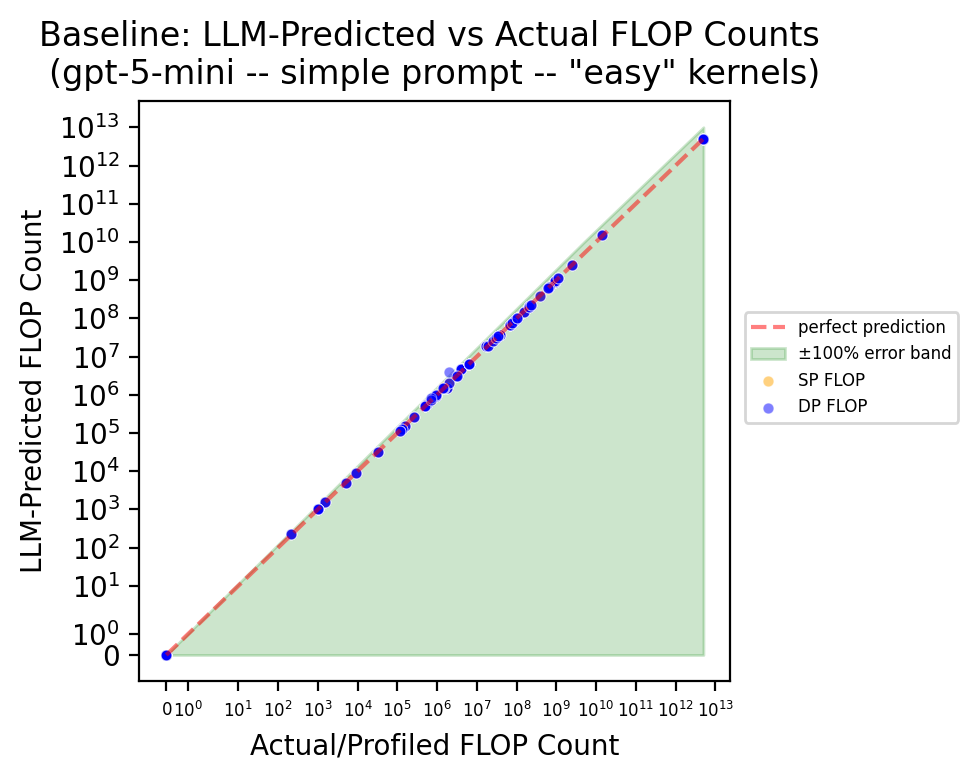

SP Percent Diff Described: 
count    606.000000
mean       0.400362
std        2.948844
min      -16.666343
25%        0.000000
50%        0.000000
75%        0.000000
max       19.855780
Name: percent_diff_sp, dtype: float64
 median: 0.0004383671871361595
DP Percent Diff Described: 
count    606.000000
mean       0.607758
std        5.058968
min      -16.666343
25%        0.000000
50%        0.000000
75%        0.000000
max       99.999504
Name: percent_diff_dp, dtype: float64
 median: 0.0005722078981498552


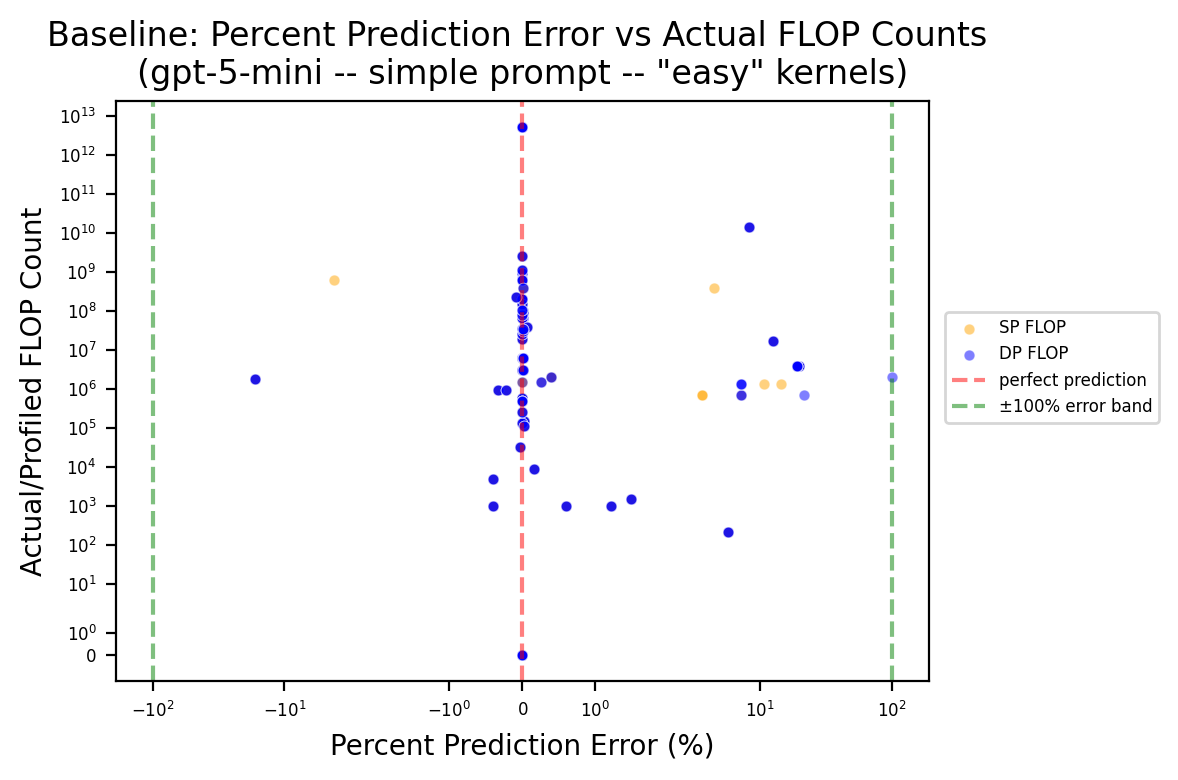

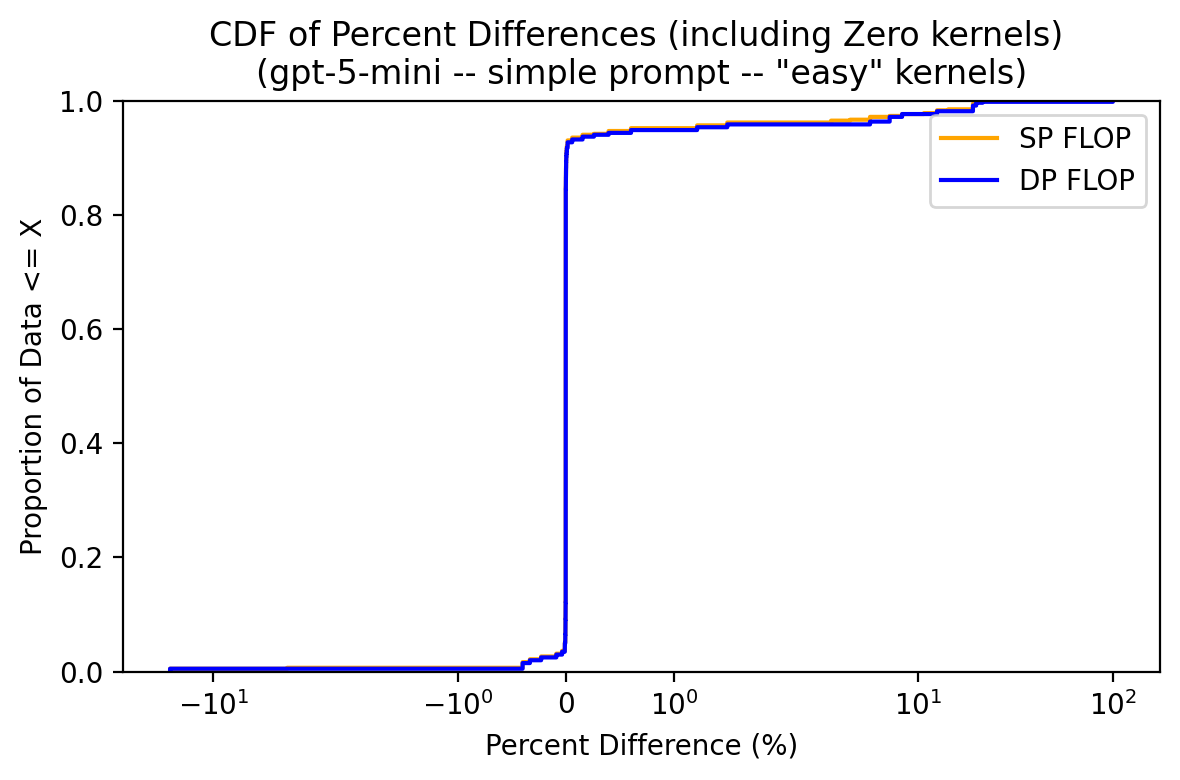

SP FLOP: 573 / 606 (94.55%) within +/- 1%
SP FLOP: 33 / 606 (5.45%) outside +/- 1%
DP FLOP: 572 / 606 (94.39%) within +/- 1%
DP FLOP: 34 / 606 (5.61%) outside +/- 1%


SP FLOP: 583 / 606 (96.20%) within +/- 5%
SP FLOP: 23 / 606 (3.80%) outside +/- 5%
DP FLOP: 578 / 606 (95.38%) within +/- 5%
DP FLOP: 28 / 606 (4.62%) outside +/- 5%


SP FLOP: 589 / 606 (97.19%) within +/- 10%
SP FLOP: 17 / 606 (2.81%) outside +/- 10%
DP FLOP: 589 / 606 (97.19%) within +/- 10%
DP FLOP: 17 / 606 (2.81%) outside +/- 10%


SP FLOP: 606 / 606 (100.00%) within +/- 50%
SP FLOP: 0 / 606 (0.00%) outside +/- 50%
DP FLOP: 605 / 606 (99.83%) within +/- 50%
DP FLOP: 1 / 606 (0.17%) outside +/- 50%


SP FLOP: 606 / 606 (100.00%) within +/- 75%
SP FLOP: 0 / 606 (0.00%) outside +/- 75%
DP FLOP: 605 / 606 (99.83%) within +/- 75%
DP FLOP: 1 / 606 (0.17%) outside +/- 75%


SP FLOP: 606 / 606 (100.00%) within +/- 99%
SP FLOP: 0 / 606 (0.00%) outside +/- 99%
DP FLOP: 605 / 606 (99.83%) within +/- 99%
DP FLOP: 1 / 606 (0.17

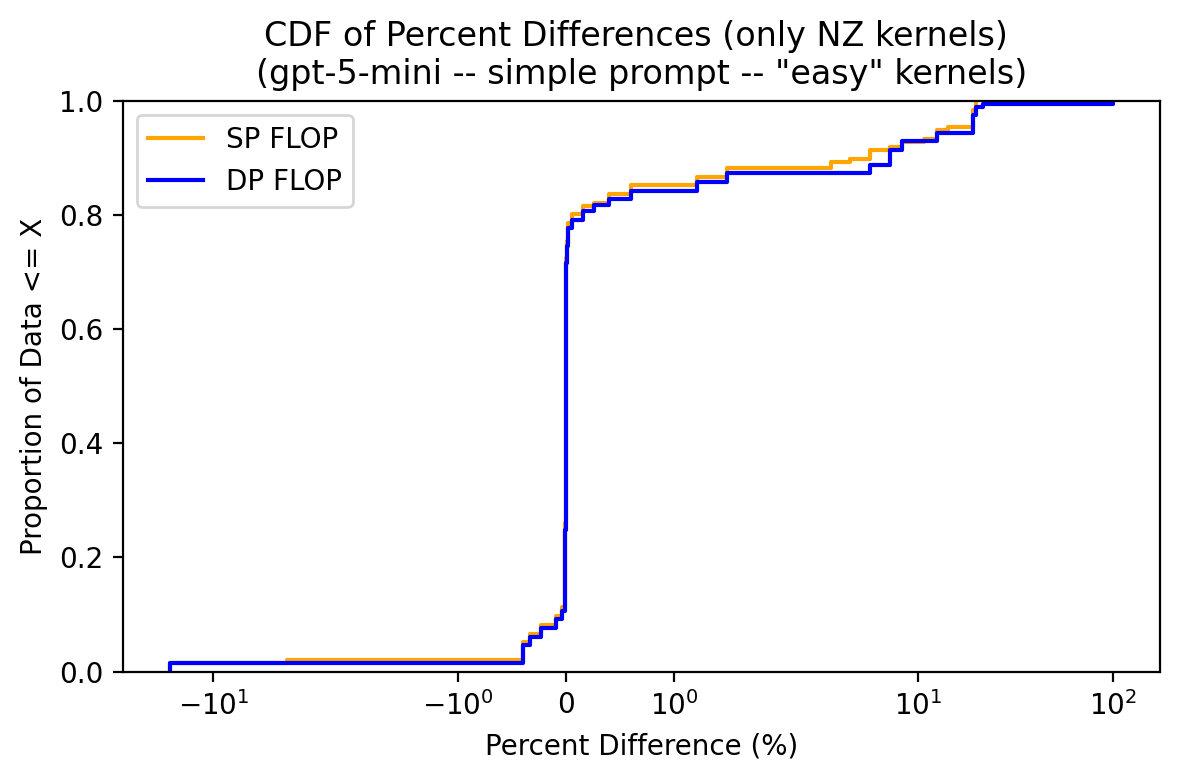

SP FLOP: 163 / 196 (83.16%) within +/- 1%
SP FLOP: 33 / 196 (16.84%) outside +/- 1%
DP FLOP: 163 / 197 (82.74%) within +/- 1%
DP FLOP: 34 / 197 (17.26%) outside +/- 1%


SP FLOP: 173 / 196 (88.27%) within +/- 5%
SP FLOP: 23 / 196 (11.73%) outside +/- 5%
DP FLOP: 169 / 197 (85.79%) within +/- 5%
DP FLOP: 28 / 197 (14.21%) outside +/- 5%


SP FLOP: 179 / 196 (91.33%) within +/- 10%
SP FLOP: 17 / 196 (8.67%) outside +/- 10%
DP FLOP: 180 / 197 (91.37%) within +/- 10%
DP FLOP: 17 / 197 (8.63%) outside +/- 10%


SP FLOP: 196 / 196 (100.00%) within +/- 50%
SP FLOP: 0 / 196 (0.00%) outside +/- 50%
DP FLOP: 196 / 197 (99.49%) within +/- 50%
DP FLOP: 1 / 197 (0.51%) outside +/- 50%


SP FLOP: 196 / 196 (100.00%) within +/- 75%
SP FLOP: 0 / 196 (0.00%) outside +/- 75%
DP FLOP: 196 / 197 (99.49%) within +/- 75%
DP FLOP: 1 / 197 (0.51%) outside +/- 75%


SP FLOP: 196 / 196 (100.00%) within +/- 99%
SP FLOP: 0 / 196 (0.00%) outside +/- 99%
DP FLOP: 196 / 197 (99.49%) within +/- 99%
DP FLOP: 1 / 197 (

/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_27639/840526316.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  percent_str = percent_str.applymap(lambda x: f"{float(x):.2f}%")


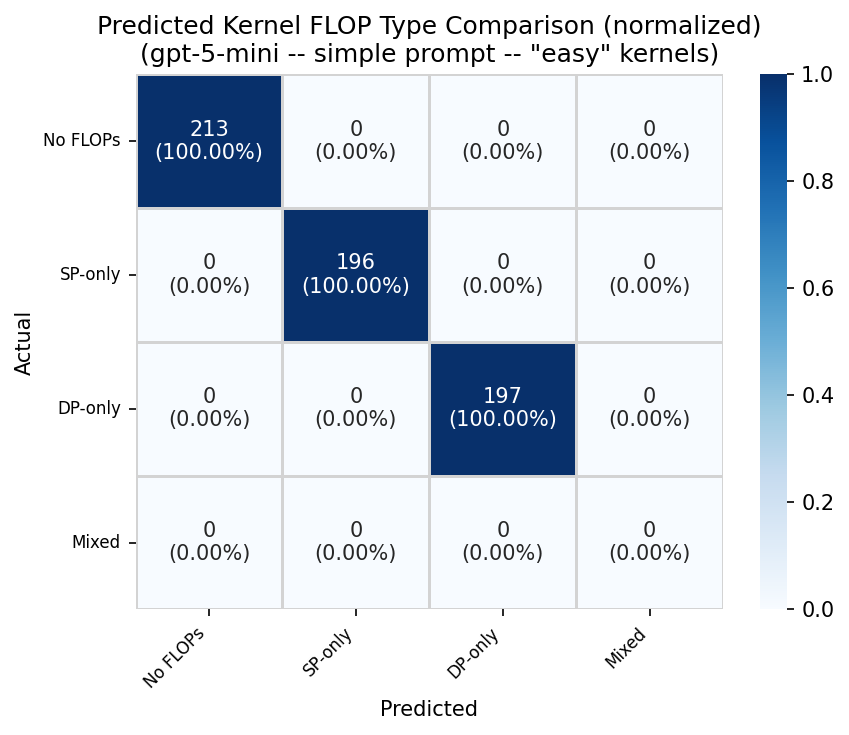

NZ SP Data Size: (196, 37)
NZ DP Data Size: (197, 37)
Mean Absolute Percent Difference SP: 1.84%
Mean Absolute Percent Difference DP: 2.42%
Median Absolute Percent Difference SP: 0.00%
Median Absolute Percent Difference DP: 0.00%
Mean Absolute Percent Difference SP (zero FLOP): 0.00%
Mean Absolute Percent Difference DP (zero FLOP): 0.00%
Median Absolute Percent Difference SP (zero FLOP): 0.00%
Median Absolute Percent Difference DP (zero FLOP): 0.00%


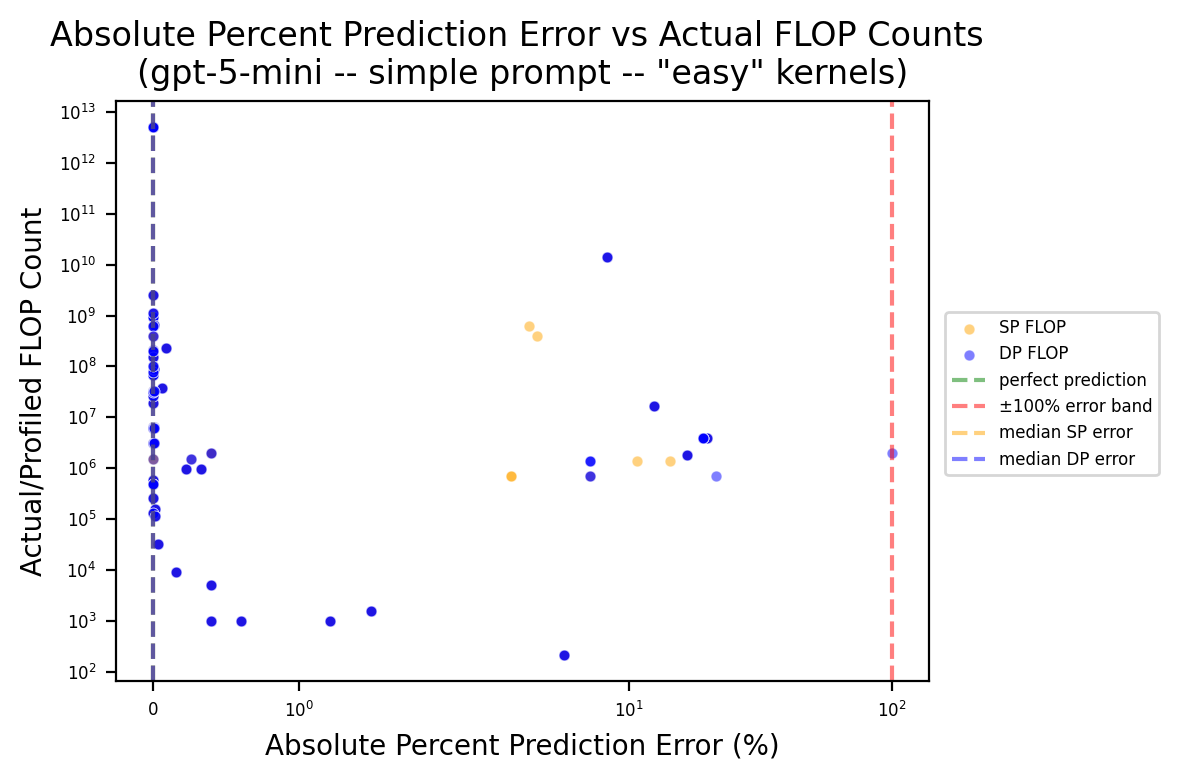

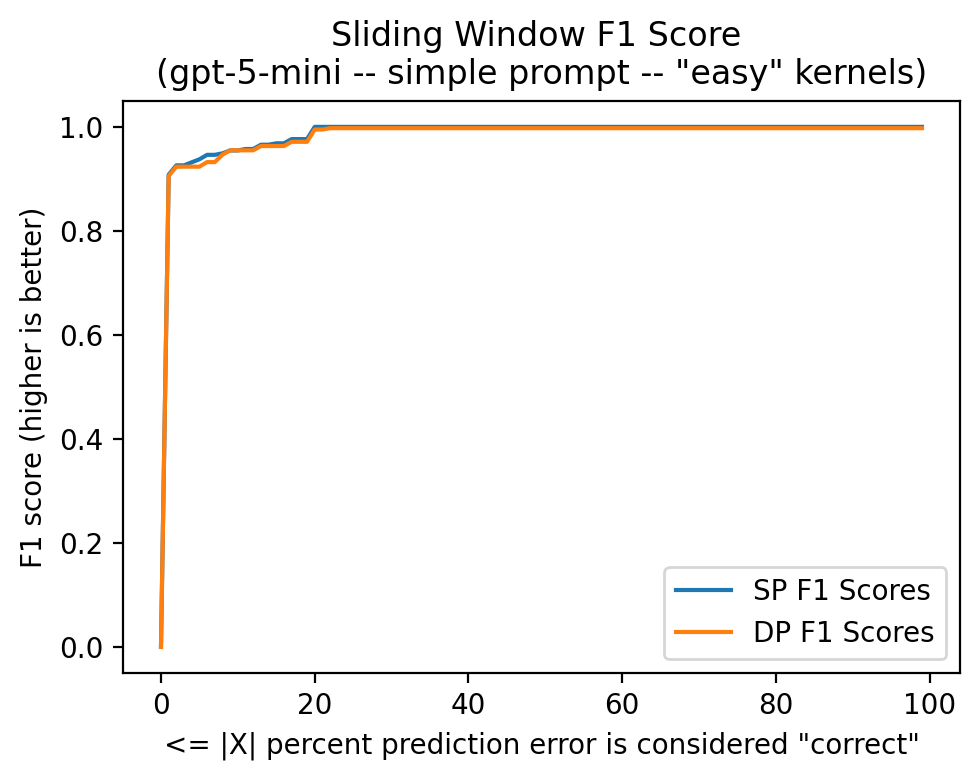

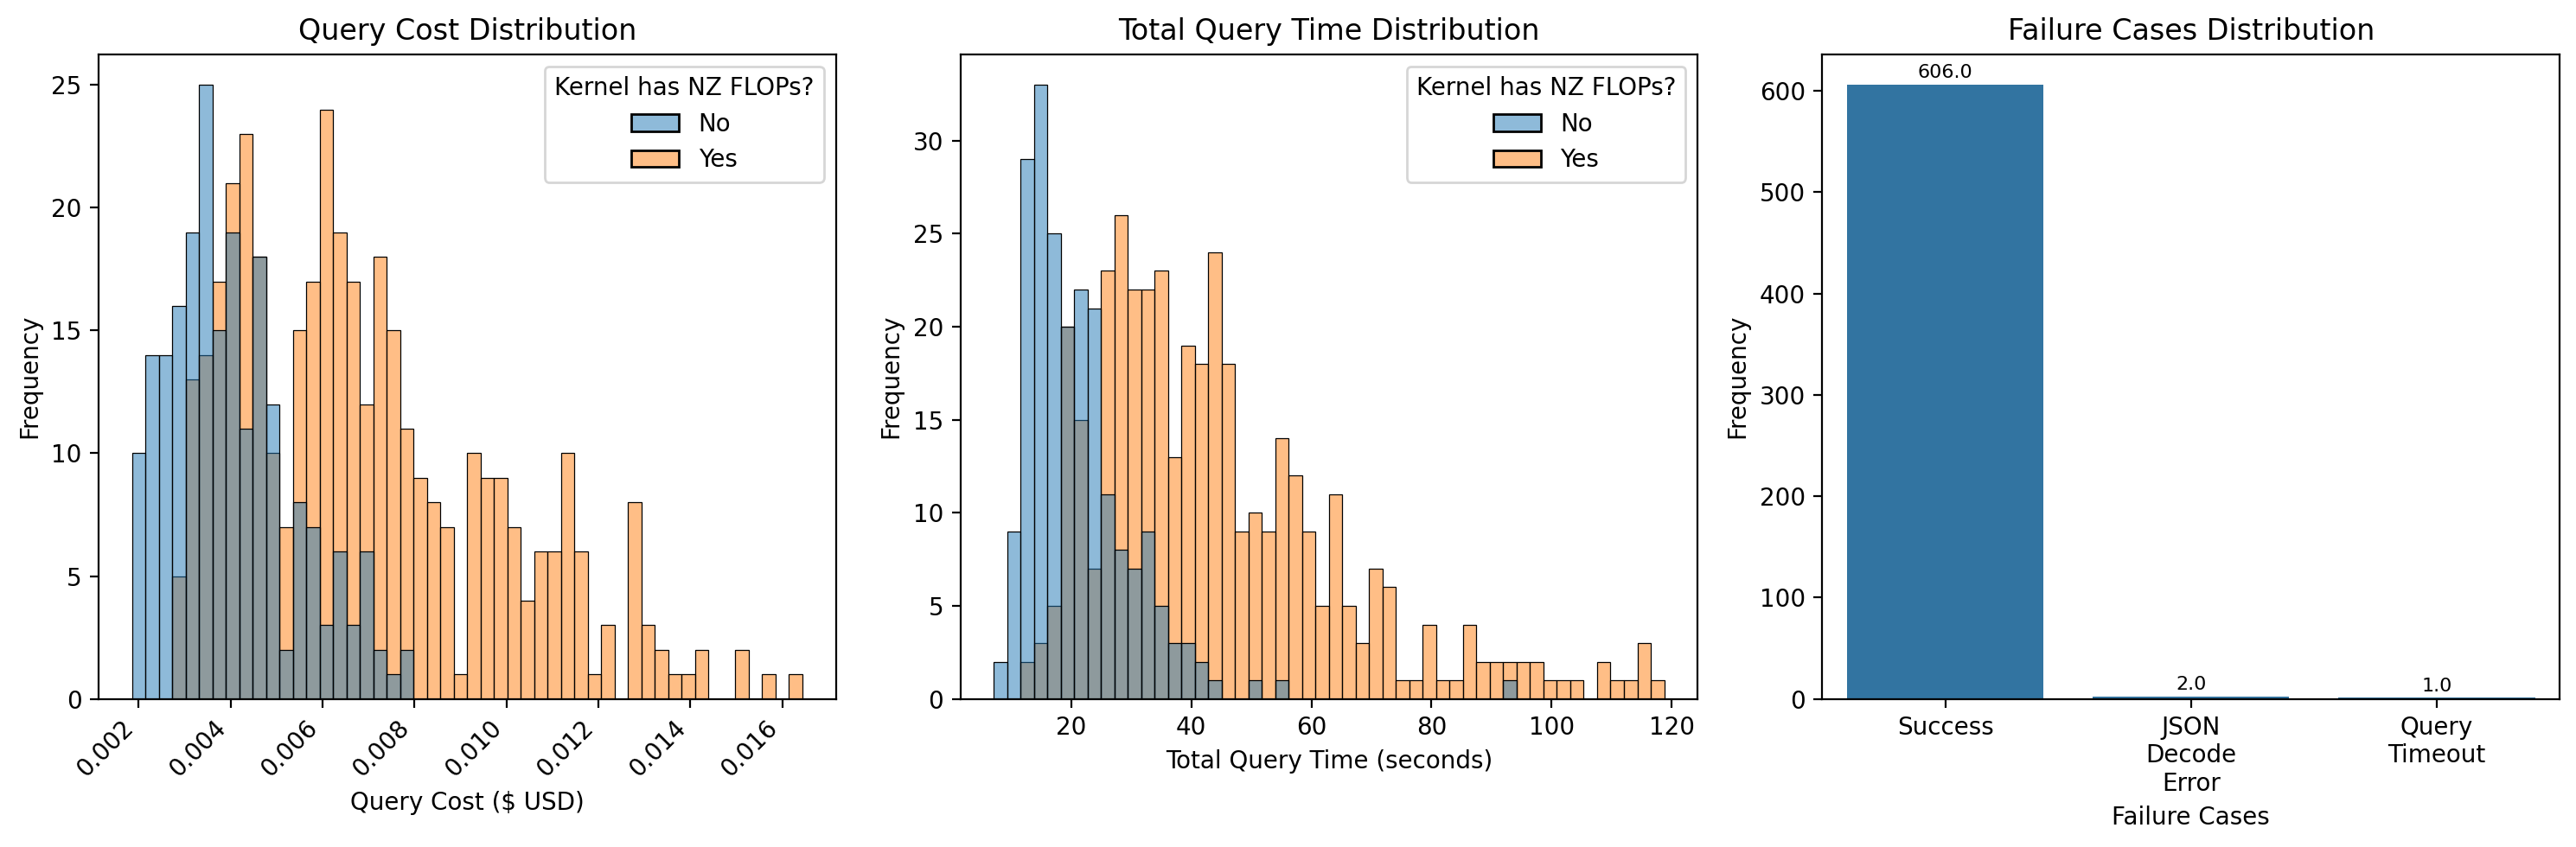

Success DF Size: (606, 36)


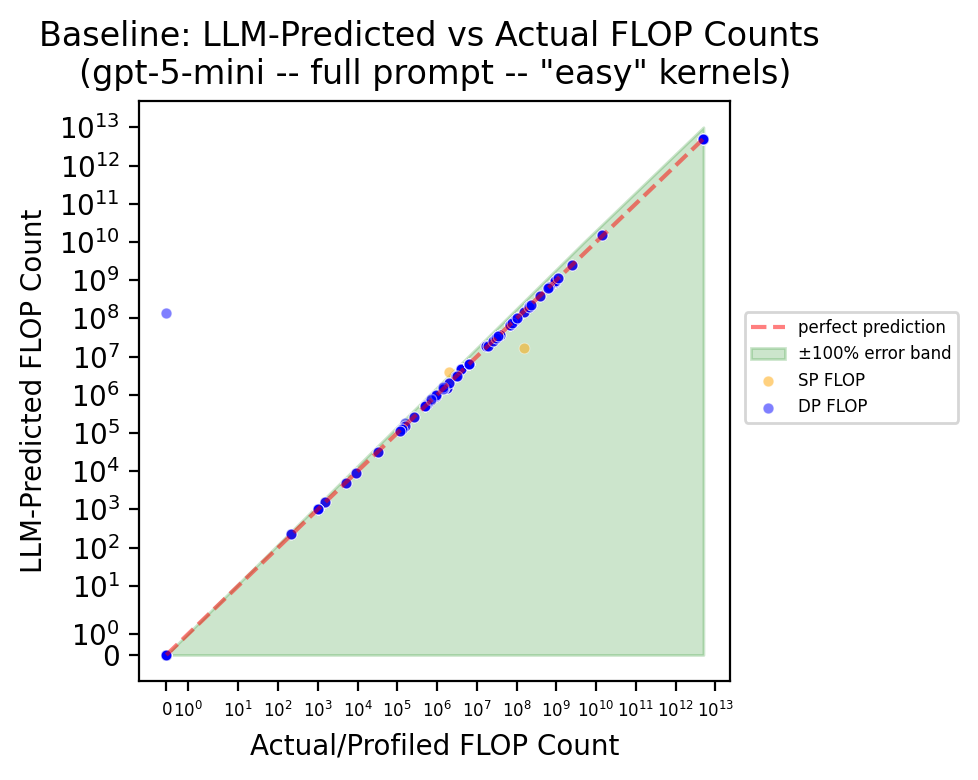

SP Percent Diff Described: 
count    606.000000
mean       0.410968
std        6.165704
min      -88.889072
25%        0.000000
50%        0.000000
75%        0.000000
max       99.999504
Name: percent_diff_sp, dtype: float64
 median: 0.0005722078981498552
DP Percent Diff Described: 
count    6.060000e+02
mean     2.214814e+16
std      5.452223e+17
min     -1.666634e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.342177e+19
Name: percent_diff_dp, dtype: float64
 median: 0.0005722078981498552


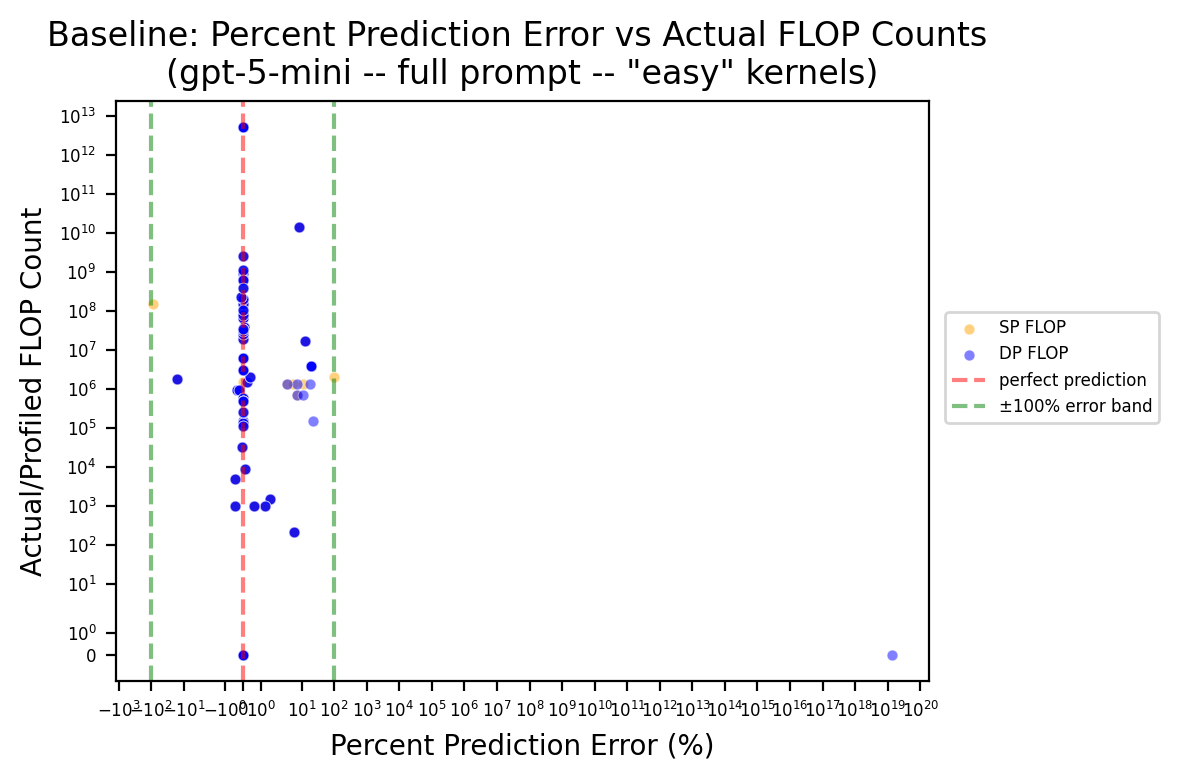

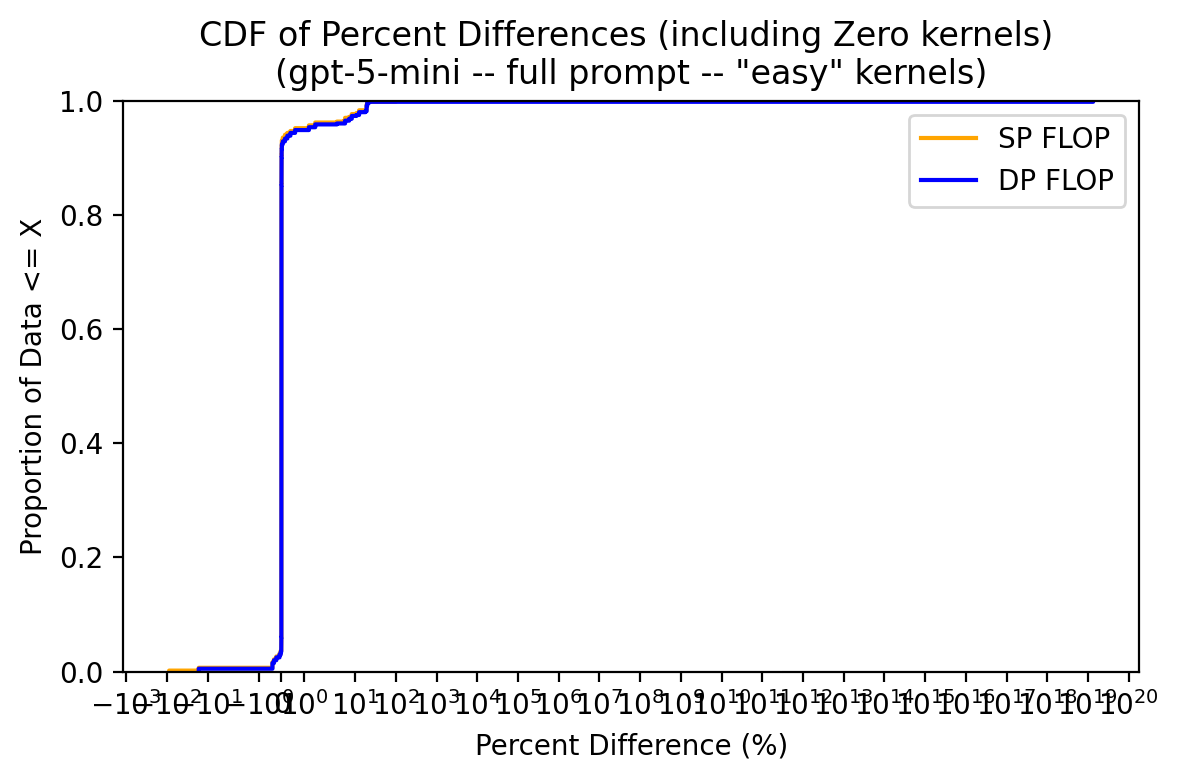

SP FLOP: 573 / 606 (94.55%) within +/- 1%
SP FLOP: 33 / 606 (5.45%) outside +/- 1%
DP FLOP: 572 / 606 (94.39%) within +/- 1%
DP FLOP: 34 / 606 (5.61%) outside +/- 1%


SP FLOP: 580 / 606 (95.71%) within +/- 5%
SP FLOP: 26 / 606 (4.29%) outside +/- 5%
DP FLOP: 579 / 606 (95.54%) within +/- 5%
DP FLOP: 27 / 606 (4.46%) outside +/- 5%


SP FLOP: 588 / 606 (97.03%) within +/- 10%
SP FLOP: 18 / 606 (2.97%) outside +/- 10%
DP FLOP: 587 / 606 (96.86%) within +/- 10%
DP FLOP: 19 / 606 (3.14%) outside +/- 10%


SP FLOP: 604 / 606 (99.67%) within +/- 50%
SP FLOP: 2 / 606 (0.33%) outside +/- 50%
DP FLOP: 605 / 606 (99.83%) within +/- 50%
DP FLOP: 1 / 606 (0.17%) outside +/- 50%


SP FLOP: 604 / 606 (99.67%) within +/- 75%
SP FLOP: 2 / 606 (0.33%) outside +/- 75%
DP FLOP: 605 / 606 (99.83%) within +/- 75%
DP FLOP: 1 / 606 (0.17%) outside +/- 75%


SP FLOP: 605 / 606 (99.83%) within +/- 99%
SP FLOP: 1 / 606 (0.17%) outside +/- 99%
DP FLOP: 605 / 606 (99.83%) within +/- 99%
DP FLOP: 1 / 606 (0.17%) 

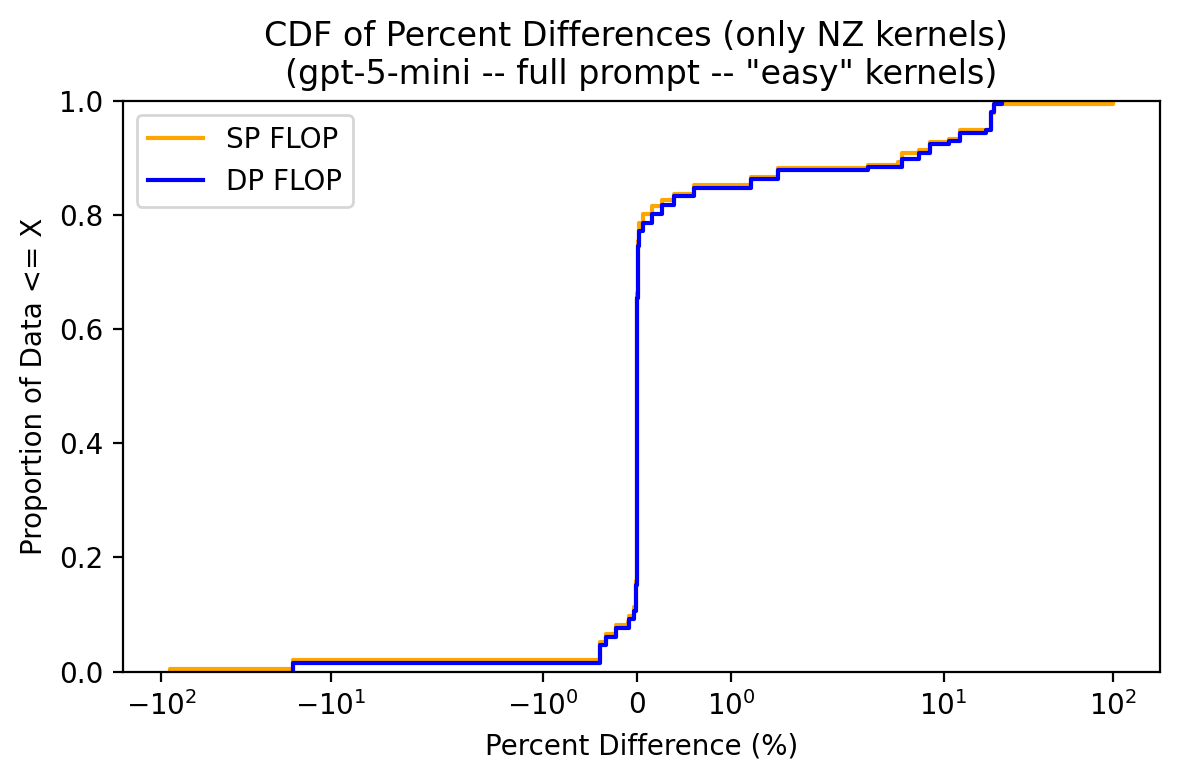

SP FLOP: 163 / 196 (83.16%) within +/- 1%
SP FLOP: 33 / 196 (16.84%) outside +/- 1%
DP FLOP: 164 / 197 (83.25%) within +/- 1%
DP FLOP: 33 / 197 (16.75%) outside +/- 1%


SP FLOP: 170 / 196 (86.73%) within +/- 5%
SP FLOP: 26 / 196 (13.27%) outside +/- 5%
DP FLOP: 171 / 197 (86.80%) within +/- 5%
DP FLOP: 26 / 197 (13.20%) outside +/- 5%


SP FLOP: 178 / 196 (90.82%) within +/- 10%
SP FLOP: 18 / 196 (9.18%) outside +/- 10%
DP FLOP: 179 / 197 (90.86%) within +/- 10%
DP FLOP: 18 / 197 (9.14%) outside +/- 10%


SP FLOP: 194 / 196 (98.98%) within +/- 50%
SP FLOP: 2 / 196 (1.02%) outside +/- 50%
DP FLOP: 197 / 197 (100.00%) within +/- 50%
DP FLOP: 0 / 197 (0.00%) outside +/- 50%


SP FLOP: 194 / 196 (98.98%) within +/- 75%
SP FLOP: 2 / 196 (1.02%) outside +/- 75%
DP FLOP: 197 / 197 (100.00%) within +/- 75%
DP FLOP: 0 / 197 (0.00%) outside +/- 75%


SP FLOP: 195 / 196 (99.49%) within +/- 99%
SP FLOP: 1 / 196 (0.51%) outside +/- 99%
DP FLOP: 197 / 197 (100.00%) within +/- 99%
DP FLOP: 0 / 197 (

/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_27639/840526316.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  percent_str = percent_str.applymap(lambda x: f"{float(x):.2f}%")


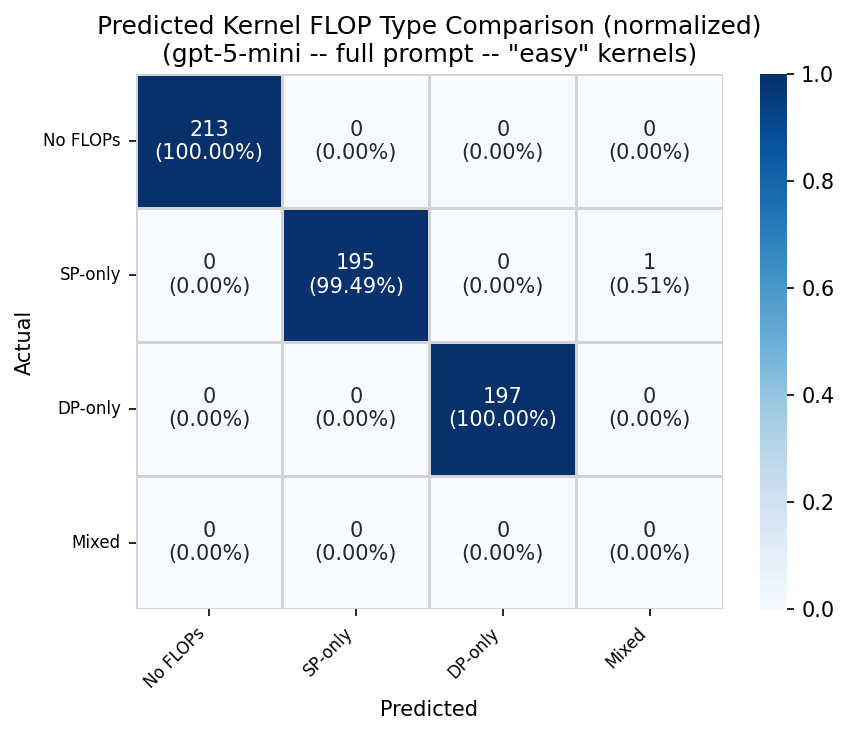

NZ SP Data Size: (196, 37)
NZ DP Data Size: (197, 37)
Mean Absolute Percent Difference SP: 2.73%
Mean Absolute Percent Difference DP: 1.98%
Median Absolute Percent Difference SP: 0.00%
Median Absolute Percent Difference DP: 0.00%
Mean Absolute Percent Difference SP (zero FLOP): 0.00%
Mean Absolute Percent Difference DP (zero FLOP): 32816070415647920.00%
Median Absolute Percent Difference SP (zero FLOP): 0.00%
Median Absolute Percent Difference DP (zero FLOP): 0.00%


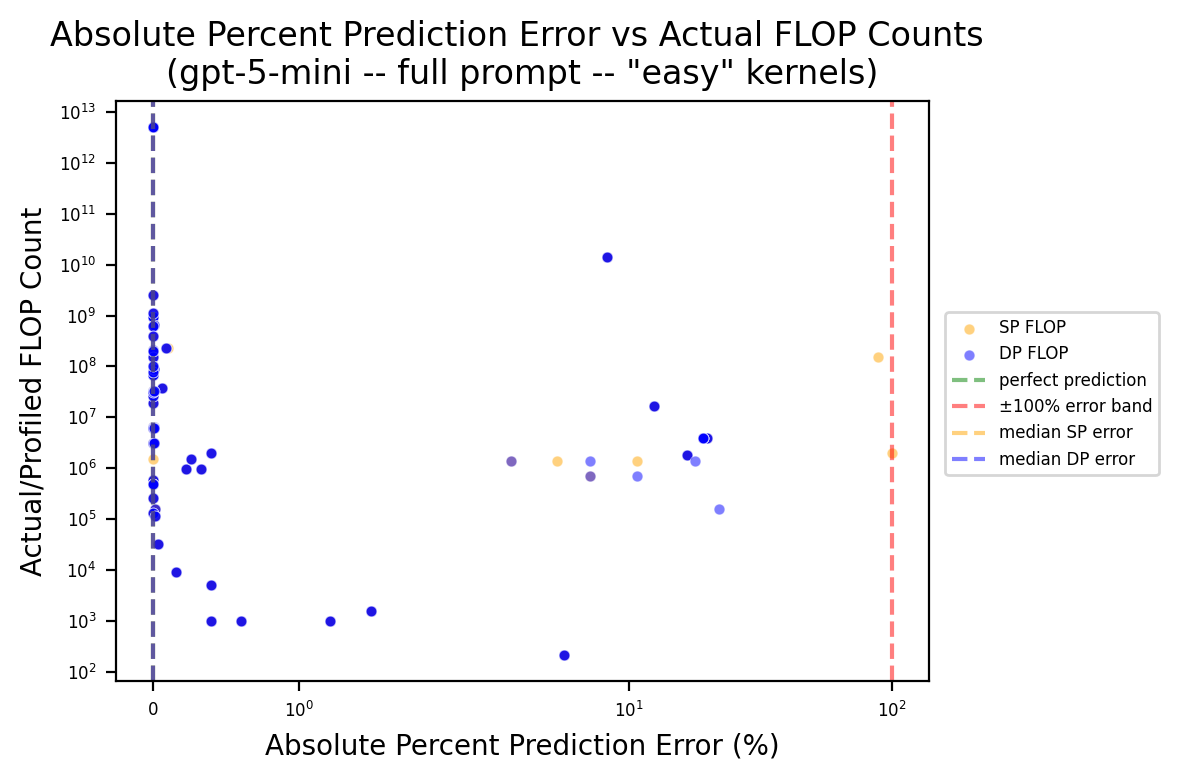

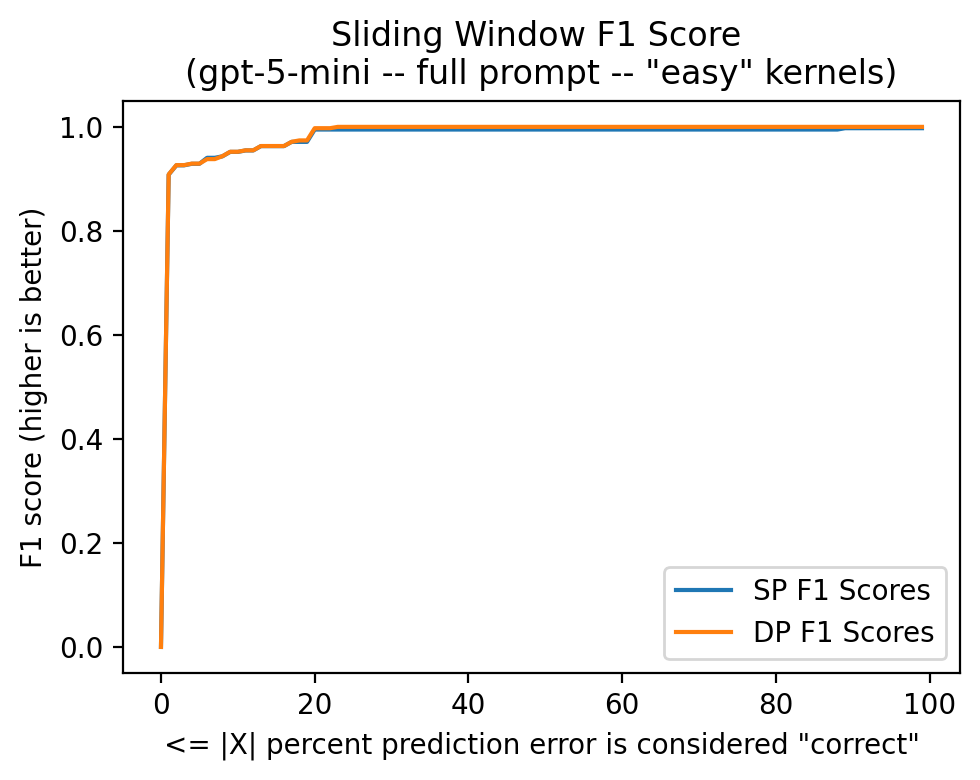

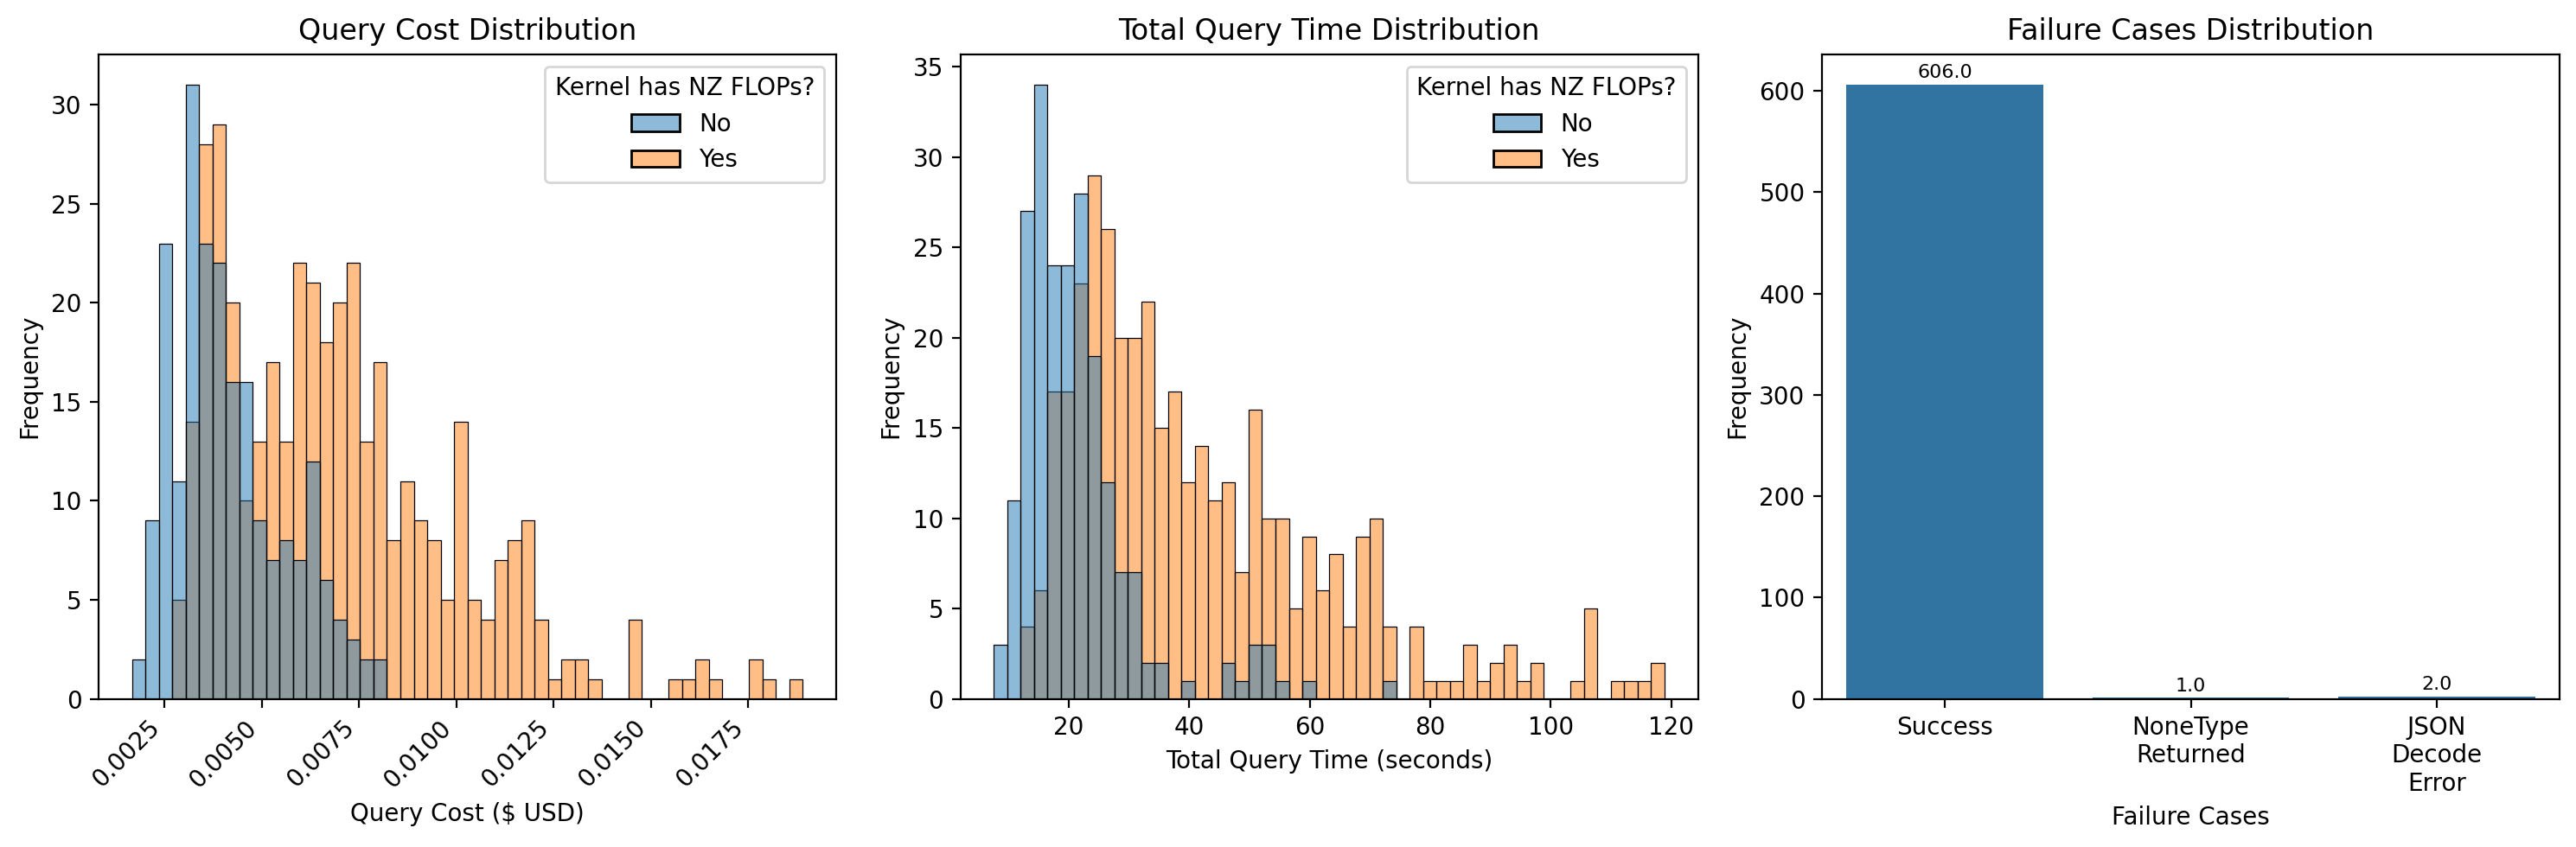

In [14]:
plot_predictions_for_model_name(df, 'gpt-5-mini', 'simple', 'easy')
plot_predictions_for_model_name(df, 'gpt-5-mini', 'full', 'easy')
#plot_predictions_for_model_name(df, 'gpt-5-mini', 'simple', 'hard')
#plot_predictions_for_model_name(df, 'gpt-5-mini', 'full', 'hard')